# Proyecto 03
## Visión Por Computadora

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
images_dir = 'imagenes/'
input_dir = 'input0'

### 2

In [12]:
def find_homography(image_data_1, image_data_2):
    sift = cv2.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(image_data_1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_data_2, None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_2, descriptors_1, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    
    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints_2[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H
    else:
        print(f"Not enough matches are found - {len(good_matches)}/{MIN_MATCH_COUNT}")
        return None


### 3

In [13]:
def warping(img1, img2, homography):
    height_img2, width_img2, _ = img2.shape
    height_img1, width_img1, _ = img1.shape
    
    corners_img2 = np.float32([[0, 0], # top-left 
                               [0, height_img2], # bottom-left
                               [width_img2, height_img2], # bottom-right
                               [width_img2, 0]]).reshape(-1,1,2) # top-right
    corners_img2 = cv2.perspectiveTransform(corners_img2, homography)

    [x_min, _] = np.int32(corners_img2.min(axis=0).ravel())
    [x_max, y_max] = np.int32(corners_img2.max(axis=0).ravel())

    x_min = min(0, x_min)
    x_max = max(width_img1, x_max)

    img_warped = cv2.warpPerspective(img2, homography, ((x_max - x_min), max(height_img1, y_max)))
    img_warped[0:height_img1, 0:width_img1] = img1

    return img_warped

IMAGE HEIGHT: 1070
IMAGE HEIGHT: 760


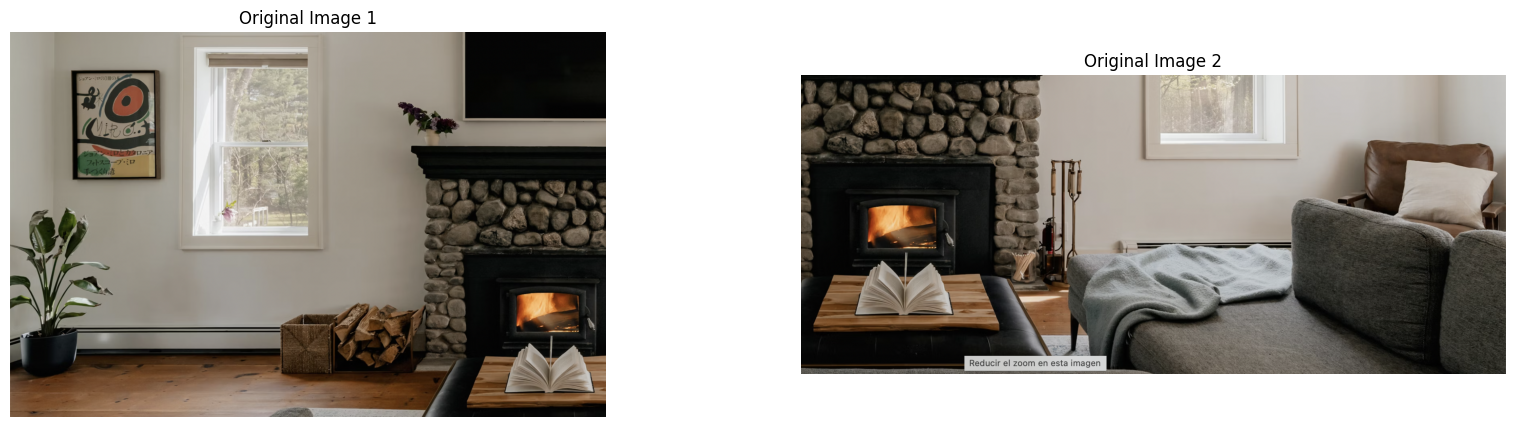

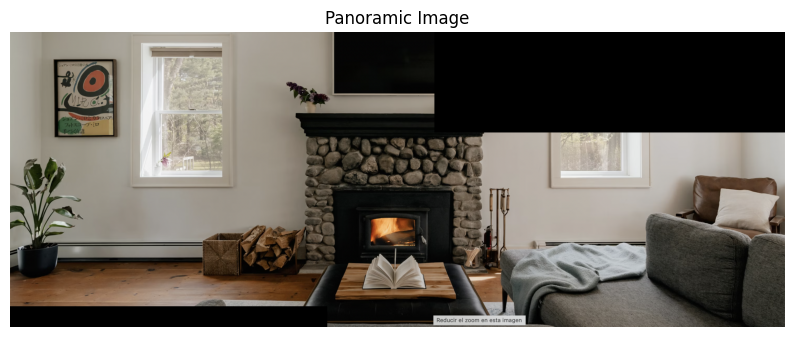

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
images = []
for i in range(2):
    image = cv2.imread(os.path.join(images_dir, input_dir, f's{i+1}.png'))
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(f'Original Image {i+1}')
    ax[i].axis('off')
    print(f"IMAGE HEIGHT: {image.shape[0]}")
    images.append(image)

homography_12 = find_homography(images[0], images[1])
warped_img_12 = warping(images[0], images[1], homography_12)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(warped_img_12, cv2.COLOR_BGR2RGB))
plt.title('Panoramic Image')
plt.axis('off')
plt.show()

IMAGE HEIGHT: 214
IMAGE HEIGHT: 210
IMAGE HEIGHT: 216


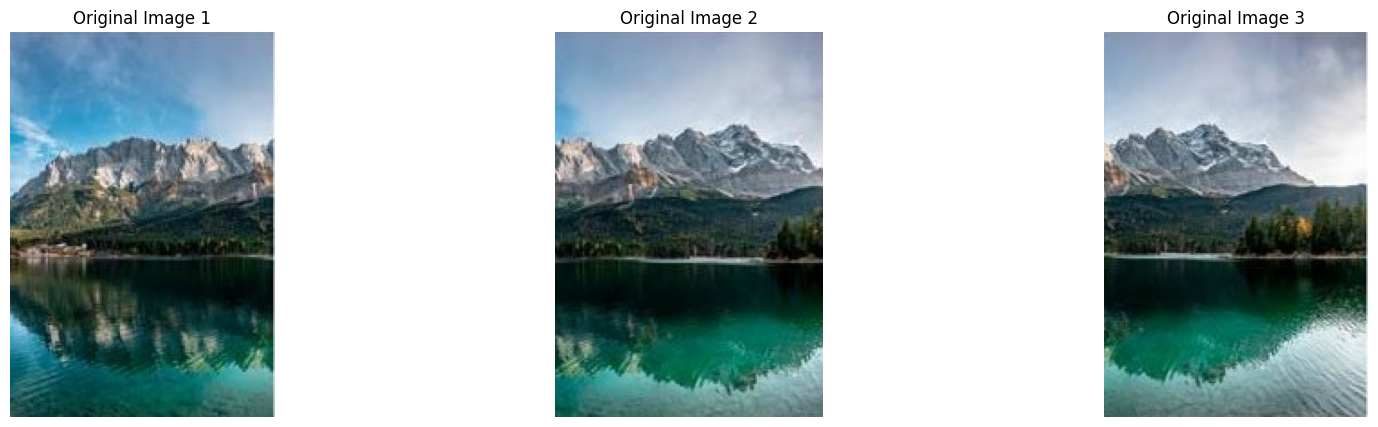

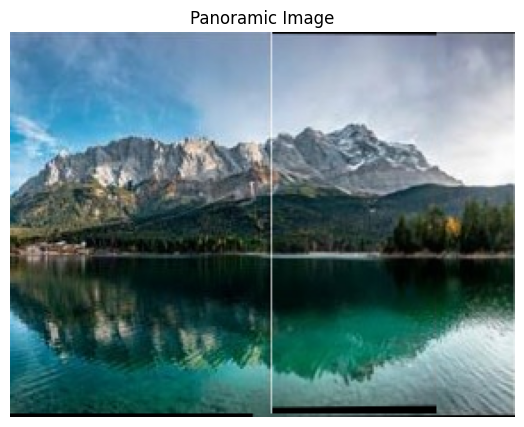

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
images = []
for i in range(3):
    image = cv2.imread(os.path.join(images_dir, input_dir, f'e{i+1}.jpg'))
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(f'Original Image {i+1}')
    ax[i].axis('off')
    print(f"IMAGE HEIGHT: {image.shape[0]}")
    images.append(image)

homography_12 = find_homography(images[0], images[1])
homography_23 = find_homography(images[1], images[2])

warped_img_12 = warping(images[0], images[1], homography_12)
final_warped_img = warping(warped_img_12, images[2], np.dot(homography_23, homography_12))

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(final_warped_img, cv2.COLOR_BGR2RGB))
plt.title('Panoramic Image')
plt.axis('off')
plt.show()

In [22]:
def find_homography(image_1_data, image_2_data):
    sift = cv2.xfeatures2d.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(image_1_data, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_2_data, None)

    brute_force_matcher = cv2.BFMatcher()
    matches = brute_force_matcher.knnMatch(descriptors_1, descriptors_2, k=2)
    good_matches = np.asarray([m for m in matches if m[0].distance < 0.7 * m[1].distance])

    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches[:, 0]]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches[:, 0]]).reshape(-1, 1, 2)

        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H

    else:
        print(f"Not enough matches - {len(good_matches)/MIN_MATCH_COUNT}")
        
def find_homography_g(image_data_1, image_data_2):
    """
    Find the homography matrix for a pair of images using SIFT, FLANN, and RANSAC.
    """
    
    sift = cv2.SIFT_create()
    
    # Find the keypoints and descriptors with SIFT
    keypoints_1, descriptors_1 = sift.detectAndCompute(image_data_1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_data_2, None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    
    MIN_MATCH_COUNT = 10
    
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        return M
    else:
        print(f"Not enough matches are found - {len(good_matches)}/{MIN_MATCH_COUNT}")
        return None

In [23]:
def warping(img1, img2, homography):
    height_img1, width_img1, _ = img1.shape
    height_img2, width_img2, _ = img2.shape

    img1_warped = cv2.warpPerspective(img1, homography, (width_img1 + width_img2, height_img2))
    img1_warped[0:height_img2, 0:width_img2] = img2

    return img1_warped

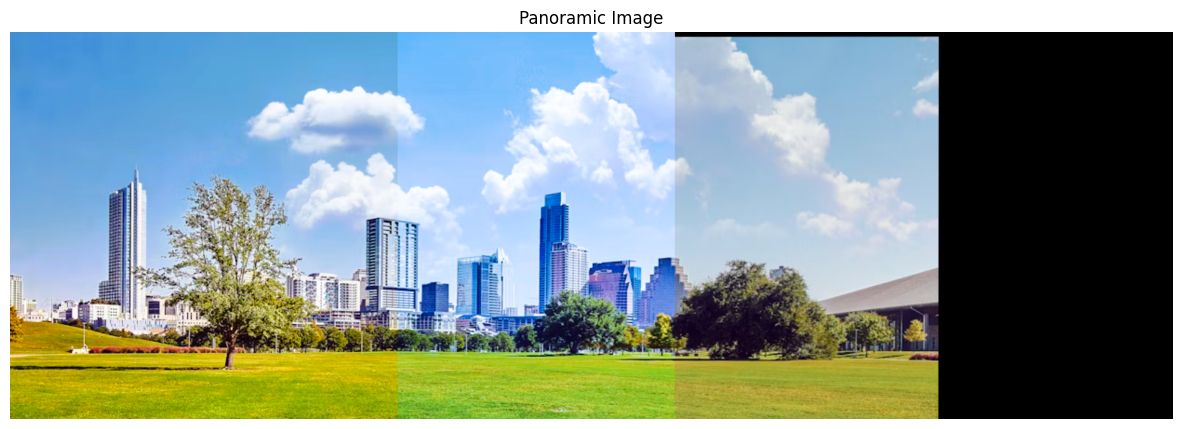

In [28]:
# Carga las imágenes
images_dir = "imagenes/input0"  # Asegúrate de definir esta variable correctamente
image_files = ['a3.png','a2.png' ,'a1.png']
images = [cv2.imread(os.path.join(images_dir, f)) for f in image_files if f]

# Calcula las homografías y crea la imagen panorámica
previous_image = images[0]
for i in range(1, len(images)):
    H = find_homography_g(previous_image, images[i])
    if H is not None:
        previous_image = warping(previous_image, images[i], H)

# Visualiza el resultado
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(previous_image, cv2.COLOR_BGR2RGB))
plt.title("Panoramic Image")
plt.axis('off')
plt.show()


## WARPING WITH BLENDING (DEGRADADO ENTRE IMAGENES)

In [19]:
def warping(img1, img2, homography):
    height_img1, width_img1 = img1.shape[:2]
    height_img2, width_img2 = img2.shape[:2]

    # Calcular dimensiones de la imagen de salida
    output_width = width_img1 + width_img2
    output_height = max(height_img1, height_img2)

    # Warp img1 con la homografía
    img1_warped = cv2.warpPerspective(img1, homography, (output_width, output_height))
    mask1_warped = cv2.warpPerspective(np.ones((height_img1, width_img1), dtype=np.uint8), homography, (output_width, output_height))

    # Preparar el canvas para el resultado final
    result = np.zeros((output_height, output_width, 3), dtype=img1.dtype)
    
    # Preparar la imagen y máscara de img2 en el canvas extendido
    img2_extended = np.zeros((output_height, output_width, 3), dtype=img2.dtype)
    img2_extended[:height_img2, :width_img2] = img2
    mask2_extended = np.zeros((output_height, output_width), dtype=np.uint8)
    mask2_extended[:height_img2, :width_img2] = 1

    # Identificar áreas de superposición y no superposición
    overlap = (mask1_warped == 1) & (mask2_extended == 1)
    non_overlap1 = (mask1_warped == 1) & (mask2_extended == 0)
    non_overlap2 = (mask1_warped == 0) & (mask2_extended == 1)

    if np.any(overlap):
        rows, cols = np.where(overlap)
        min_col, max_col = cols.min(), cols.max()
        gradient_width = max_col - min_col + 1
        alpha = np.linspace(1, 0, gradient_width)  # Invertir la dirección del degradado

        # Crear una máscara de degradado completa para la región de superposición
        full_alpha = np.zeros_like(img1_warped[:, :, 0], dtype=float)
        full_alpha[:, min_col:max_col+1] = alpha

        # Usar la máscara de degradado para el blending
        for c in range(3):  # Repetir para cada canal de color
            result[overlap, c] = (img1_warped[overlap, c] * (1 - full_alpha[overlap]) + img2_extended[overlap, c] * full_alpha[overlap]).astype(np.uint8)
    
    # Donde solo img1 tiene datos
    result[non_overlap1] = img1_warped[non_overlap1]
    
    # Donde solo img2 tiene datos
    result[non_overlap2] = img2_extended[non_overlap2]

    return result


In [20]:
# Carga las imágenes
images_dir = "imagenes/input0"
image_files = ['a3.png', 'a2.png', 'a1.png']
images = [cv2.imread(os.path.join(images_dir, f)) for f in image_files if f]

# Calcula las homografías y crea la imagen panorámica
previous_image = images[0]
for i in range(1, len(images)):
    H = find_homography(previous_image, images[i])
    if H is not None:
        previous_image = warping(previous_image, images[i], H)

# Visualiza el resultado
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(previous_image, cv2.COLOR_BGR2RGB))
plt.title("Panoramic Image")
plt.axis('off')
plt.show()


AttributeError: module 'cv2' has no attribute 'xfeatures2d'